In [2]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Neural Network ML

In [3]:
seed = 42
np.random.seed(seed)

df = pd.read_csv('dataset.csv')
display(df.head())
print(f'Number of samples: {df.shape[0]}')

,rating_mean,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,3.893708,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,...,0,0,0,0,0,0,0,0,0,0
1,3.251527,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,...,0,0,0,0,0,0,0,0,0,0
2,3.142028,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,...,0,0,0,0,0,1,0,0,0,0
3,2.853547,0.03425,0.03800,0.04050,0.03100,0.06500,0.03575,0.02900,0.08650,0.0320,...,0,0,0,0,0,1,0,0,0,0
4,3.058434,0.04300,0.05325,0.03800,0.04100,0.05400,0.06725,0.02775,0.07650,0.0215,...,0,0,0,0,0,0,0,0,0,0


Number of samples: 13798


In [4]:
# PyTorch Device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print("Using {} device".format(device))

Using cuda device


### Data Preprocessing

In [5]:
X = df.drop('rating_mean', axis=1)
y = df['rating_mean']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)

X_train = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val.values, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [6]:
print('Number of training samples:', X_train.shape[0])
print('Number of validation samples:', X_val.shape[0])
print('Number of test samples:', X_test.shape[0])

b_size = 32

train_set = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=b_size,
                                        shuffle=True)
val_set = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val, y_val), batch_size=b_size, shuffle=True)
test_set = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=b_size, shuffle=True)

Number of training samples: 9934
Number of validation samples: 1104
Number of test samples: 2760


### Defining the neural network architecture

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_p, depth):
        super(NeuralNetwork, self).__init__()

        model = [
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        ]

        for i in range(depth):
            model.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            model.append(nn.ReLU())
            model.append(nn.Dropout(dropout_p))

        model.append(nn.Linear(hidden_sizes[-1], 1))  # output layer

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)
    #x.squeeze()

In [8]:
# Hyperparameters
input_size = X_train.shape[1]
hidden_size = [128, 256, 128]  # 128
dropout_p = 0.2
depth = 3
learning_rate = 1e-3
num_epochs = 200

model = NeuralNetwork(input_size, hidden_size, dropout_p, depth).to(device)
print("Model structure: \n ", model)

Model structure: 
  NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=1147, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [9]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# Training model function
def train_model(model, criterion, optimizer, num_epochs, train_set, val_set):
    writer = SummaryWriter('runs/nn')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_set:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_set.dataset)

        model.eval()
        val_loss = 0.0
        for inputs, targets in val_set:
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_set.dataset)

        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)

        print(f'Epoch: {epoch + 1}/{num_epochs} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}')

    writer.flush()
    writer.close()

    return model


In [11]:
# Testing model function
def test_model(model, data_loader):
    model.eval()
    test_loss = 0.0
    y_true = []
    y_pred = []

    for inputs, targets in data_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item() * inputs.size(0)
        y_true.extend(targets.tolist())
        y_pred.extend(outputs.tolist())

    test_loss /= len(data_loader.dataset)

    return test_loss, y_true, y_pred

In [12]:
# Training the model
print("Hyperparameters used in this run:")
print(f"Learning rate: {learning_rate}")
print(f"Number of epochs: {num_epochs}")
print(f"Batch size: {train_set.batch_size}")
print(f"Dropout probability: {dropout_p}")
print(f"Number of layers: {depth}")
print(f"Number of neurons per layer: {hidden_size}")
print("\n")

model = train_model(model, criterion, optimizer, num_epochs, train_set, val_set)

Hyperparameters used in this run:
Learning rate: 0.001
Number of epochs: 200
Batch size: 32
Dropout probability: 0.2
Number of layers: 3
Number of neurons per layer: [128, 256, 128]


Epoch: 1/200 | Train loss: 0.5589 | Val loss: 0.1520
Epoch: 2/200 | Train loss: 0.1137 | Val loss: 0.0308
Epoch: 3/200 | Train loss: 0.0928 | Val loss: 0.0169
Epoch: 4/200 | Train loss: 0.0844 | Val loss: 0.0175
Epoch: 5/200 | Train loss: 0.0826 | Val loss: 0.0300
Epoch: 6/200 | Train loss: 0.0760 | Val loss: 0.0109
Epoch: 7/200 | Train loss: 0.0712 | Val loss: 0.0119
Epoch: 8/200 | Train loss: 0.0699 | Val loss: 0.0341
Epoch: 9/200 | Train loss: 0.0704 | Val loss: 0.0119
Epoch: 10/200 | Train loss: 0.0656 | Val loss: 0.0195
Epoch: 11/200 | Train loss: 0.0625 | Val loss: 0.0236
Epoch: 12/200 | Train loss: 0.0633 | Val loss: 0.0083
Epoch: 13/200 | Train loss: 0.0553 | Val loss: 0.0108
Epoch: 14/200 | Train loss: 0.0558 | Val loss: 0.0277
Epoch: 15/200 | Train loss: 0.0527 | Val loss: 0.0109
Epoch: 16/200 |

In [13]:
# Testing the model
print("Testing the model")
test_loss, y_true, y_pred = test_model(model, test_set)
print(f'Test loss: {test_loss}')

r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print(f'R2 score: {r2}')
print(f'MSE: {mse}')

Testing the model
Test loss: 0.007294755044352749
R2 score: 0.9676592901818742
MSE: 0.00729475508198336


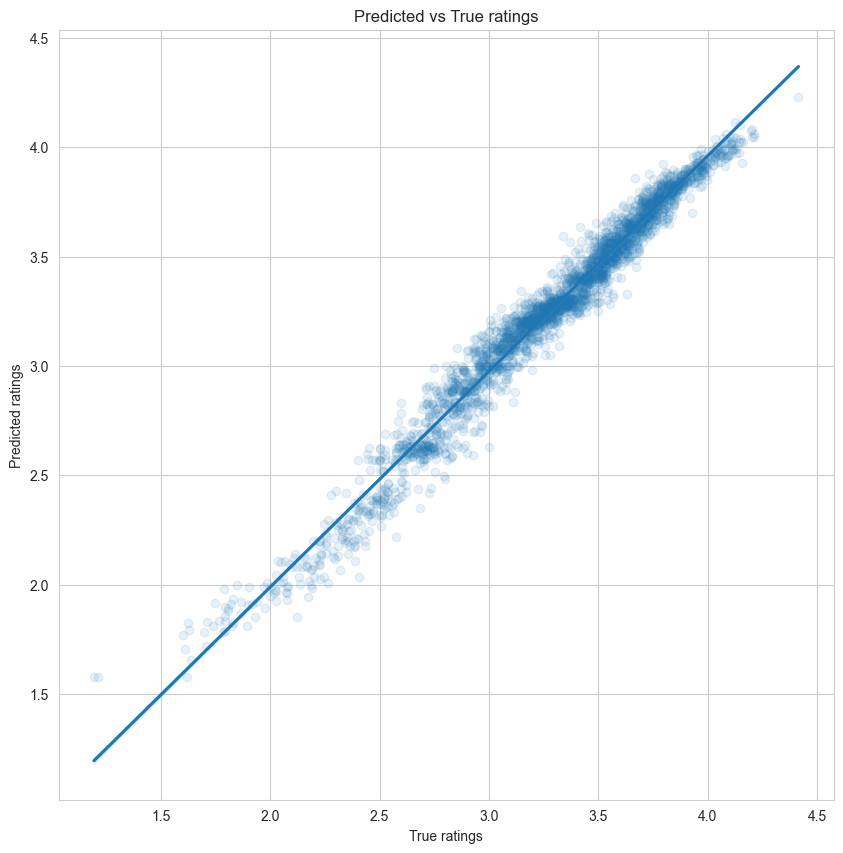

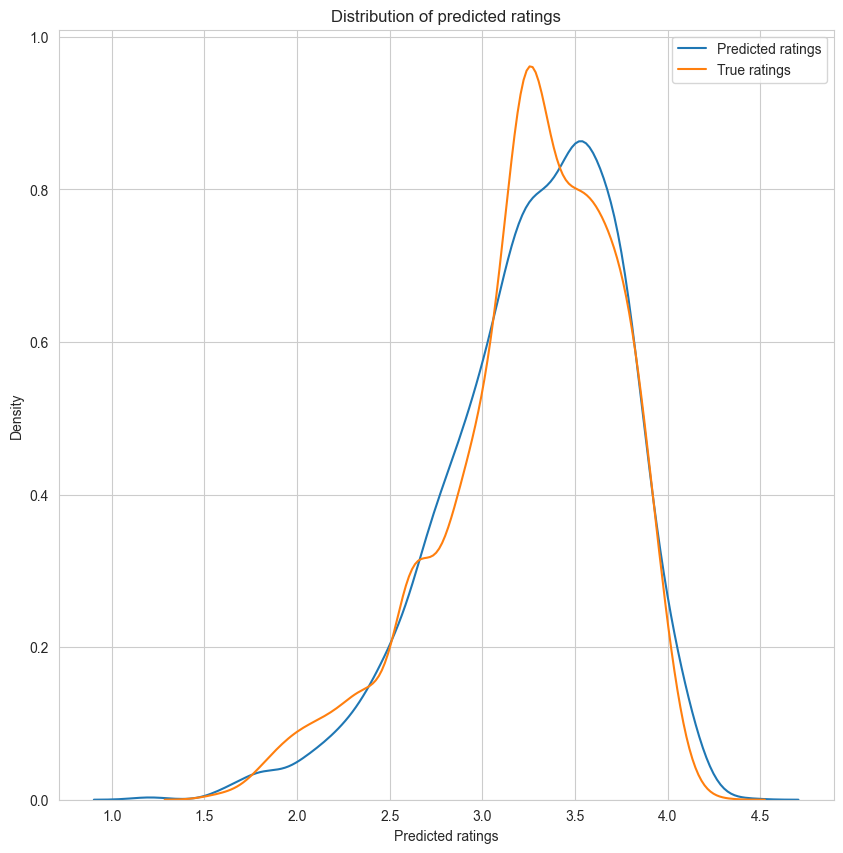

In [14]:
# Plotting the results
plt.figure(figsize=(10, 10))
sns.regplot(x=y_true, y=y_pred, scatter_kws={'alpha': 0.1})
plt.xlabel('True ratings')
plt.ylabel('Predicted ratings')
plt.title('Predicted vs True ratings')
plt.show()

# Distribution of predicted ratings
plt.figure(figsize=(10, 10))
y_pred = np.array(y_pred)
sns.kdeplot(y_true)
sns.kdeplot(y_pred.flatten())
plt.legend(['Predicted ratings', 'True ratings'])
plt.xlabel('Predicted ratings')
plt.title('Distribution of predicted ratings')
plt.show()